In [1]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}
</style>
""")

# $$\textbf{Python Programming for Machine Learning} $$ 

#### $$\text{SoSe 2020}$$

## $$\text{Lecture 4: Numerical instability, Linear Algebra} $$

#### $$\text{Sergej Dogadov} \quad \text{Philine Thalia Görzig} \quad \text{Panagiotis Tomer Karagiannis}$$

<center>
<img src='images/pyt.png' width=250>

## $$\textbf{Rounding effect}$$
<hr>
<br>

In [2]:
# Import the required packages
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

* $\text{Let's start with a weird experiment:}$

In [3]:
a = (10**np.arange(4)).astype('float32')
a

array([   1.,   10.,  100., 1000.], dtype=float32)

In [4]:
# Add and subtract the same (huge) number
huge_number = 1e9 

(a + huge_number) - huge_number # as you can see the result is not equal a

array([   0.,    0.,  128., 1024.], dtype=float32)

* $ \text{Now, let's repeat the experiment with higher precision (float64):} $

In [5]:
a = (10**np.arange(4)).astype('float64')
a

array([   1.,   10.,  100., 1000.])

In [6]:
huge_number = 1e12

# it seems to work now
(a + huge_number) - huge_number # ok for now it works...

array([   1.,   10.,  100., 1000.])

* $\text{We can also reach the limits of double precision floats (float64):}$

In [7]:
huge_number = 1e18 

print((a + huge_number) - huge_number) # same artefacts appear

[   0.    0.  128. 1024.]


## $$\textbf{Understanding of the rounding effect}$$
<hr>
<br>

In [8]:
# We'll plot all numbers before and after application of the addition and substraction of the huge numbers:
a = np.arange(500).astype('float32')

huge_numbers = [1e7, 1e8, 1e9, 1e10]

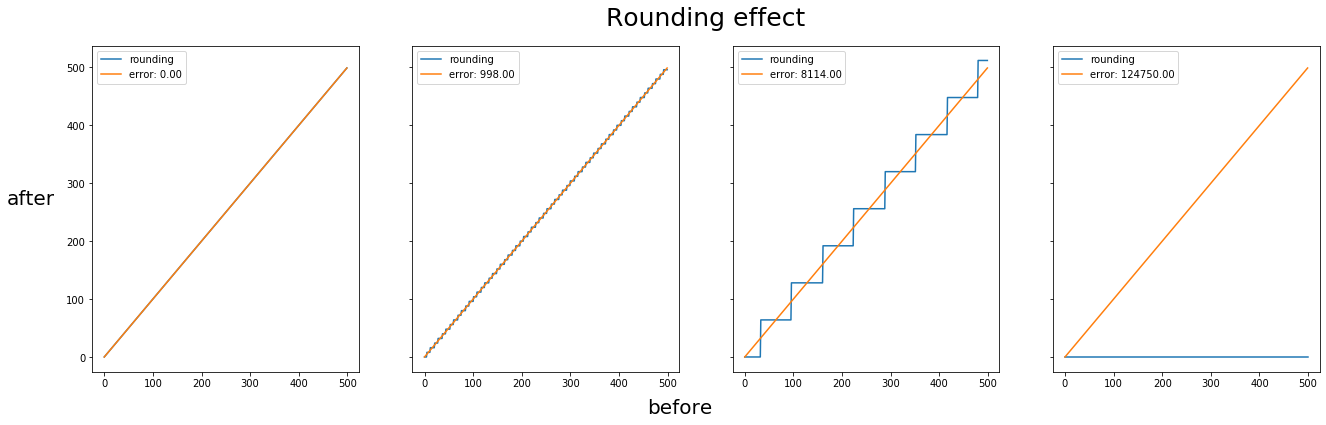

In [9]:
f, axis = plt.subplots(1, len(huge_numbers), sharex=True, sharey=True, figsize = (22,6))

for i,num in enumerate(huge_numbers):
    ax = axis[i]
    b = (a + num) - num
    ax.plot(a, b, label='rounding')
    ax.plot(a, a, label=f'error: {np.abs(a-b).sum():.2f}')
    ax.legend()
    
ttl = axis[1].set_title('Rounding effect', fontsize=25, pad=20)
axis[0].set_ylabel('after', rotation=0, labelpad=35, fontsize=20)
xlab =  axis[1].set_xlabel('before', fontsize=20, labelpad=10) # pad to get vert dist
ttl.set_position([1.1,1.0])
xlab.set_position([1, 0]) # shifting to right (centering)

## $$\textbf{Insights about the rounding effect}$$
<hr>
<br>

* The `float32` and `float64` number representations have a certain budget of bits to represent real numbers.

Therefore, they allocate precision where it is important (e.g. for small numbers).
<br>



* The smaller the precision, the less memory is used and therefore the more efficient (computationally), 

but also the more careful we should be about potential loss of precision.
<br>



* Unlike typical observed data, error is not random-looking, but very structured.

## $$\textbf{Rounding error structure}$$
<hr>
<br>

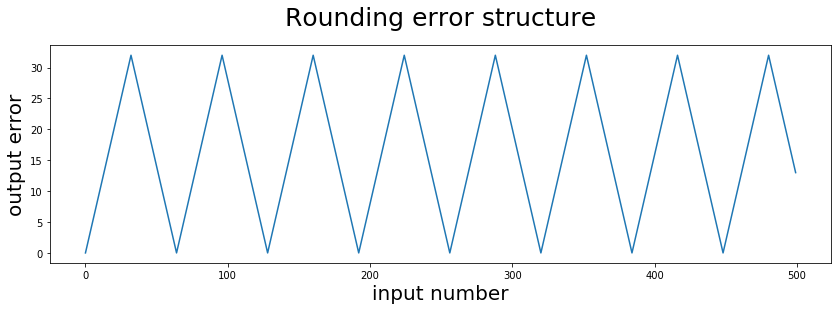

In [10]:
num = 1e9

a = np.arange(500).astype('float32')

b = (a + num) - num
error = np.abs(a - b)

plt.figure(figsize=(14,4))
plt.plot(a, error)
plt.title('Rounding error structure', fontsize=25, pad=20)
plt.xlabel('input number', fontsize=20)
_=plt.ylabel('output error', fontsize=20)

## $$\textbf{Overflow}$$
<hr>
<br>

* $\text{Overflow is a frequently encountered problem when implementing machine learning algorithms.}$

In [11]:
a = 10**np.arange(1,4).astype('float64')
a

array([  10.,  100., 1000.])

In [12]:
# exponential function overflow
np.exp(a)

C:\Users\Mayank\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


array([2.20264658e+04, 2.68811714e+43,            inf])

## $$\textbf{Example: sigmoid function}$$
<hr>
<br>

$${\sigma(x) = \frac{e^{x}}{1+e^{x}}}$$

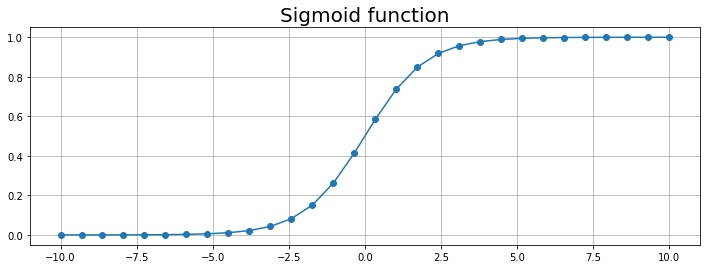

In [13]:
sigmoid = lambda x: np.exp(x) / (1 + np.exp(x))

x = np.linspace(-10,10,30)
plt.figure(figsize=(12,4))
plt.title('Sigmoid function', fontsize=20)
plt.plot(x,sigmoid(x),'o-')
plt.grid(1)

## $$\textbf{Compute sigmoid function for some values}$$
<hr>
<br> 

In [14]:
x = 10. ** np.arange(0,5)
x = np.sort(np.concatenate([-x,x])) # huge negative and positive numbers
x

array([-1.e+04, -1.e+03, -1.e+02, -1.e+01, -1.e+00,  1.e+00,  1.e+01,
        1.e+02,  1.e+03,  1.e+04])

In [15]:
sigmoid(x)

C:\Users\Mayank\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
C:\Users\Mayank\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


array([0.00000000e+00, 0.00000000e+00, 3.72007598e-44, 4.53978687e-05,
       2.68941421e-01, 7.31058579e-01, 9.99954602e-01, 1.00000000e+00,
                  nan,            nan])

* $\text{Where does the `nan` come from?}$

In [16]:
# Undefined mathematical operations

np.inf/np.inf, 0.*np.inf,  np.inf - np.inf

(nan, nan, nan)

In [17]:
# Undefined mathematical operations but works in python

1.** np.inf, 0.**np.inf, 0.**0

(1.0, 0.0, 1.0)

## $$\textbf{Stable sigmoid function}$$
<hr>
<br> 

* $\text{Let's rewrite the sigmoid function in a different way}$

$$
\sigma(x) = \frac{e^{x}}{1+e^{x}} = \frac{e^{-x} e^{x}}{e^{-x} (1+e^{x})} = \frac{1}{1+e^{-x}}
$$

In [18]:
sigmoid = lambda x: 1./(1 + np.exp(-x))
x

array([-1.e+04, -1.e+03, -1.e+02, -1.e+01, -1.e+00,  1.e+00,  1.e+01,
        1.e+02,  1.e+03,  1.e+04])

In [19]:
sigmoid(x)

C:\Users\Mayank\anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


array([0.00000000e+00, 0.00000000e+00, 3.72007598e-44, 4.53978687e-05,
       2.68941421e-01, 7.31058579e-01, 9.99954602e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00])

* $\text{Here, we still get an overflow.}$ 

$\text{But this time, we are lucky since 1/inf = 0.0, which could be the desired result for large negative inputs.}$

## $$\textbf{Robust sigmoid function}$$
<hr>
<br> 

* $\text{The sigmoid function can be written in yet another way using} \> \tanh(x)\> \text{function:}$

$$
\tanh{(x)} = \frac{e^{2x} - 1}{e^{2x} + 1}
$$
<hr>

$$
\sigma(x) = \frac{e^{x}}{1+e^{x}} = \frac{1}{2}\Big(\frac{2e^{x}}{1+e^{x}}\Big) = \frac{1}{2}\Big(\frac{e^{x} - 1 + 1 + e^{x}}{1+e^{x}}\Big) = \frac{1}{2}\Big( \frac{e^{x} - 1}{e^{x}+1} + 1\Big) = \frac{1}{2}\Big( \tanh\Big(\frac{x}{2}\Big) + 1\Big)
$$

In [20]:
sigmoid = lambda x: 0.5 * ( np.tanh(0.5 * x) + 1 )

# And there is no runtime warning this time.
sigmoid(x)

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.53978687e-05,
       2.68941421e-01, 7.31058579e-01, 9.99954602e-01, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00])

## $$\textbf{Clipped sigmoid function}$$
<hr>
<br> 

* $\text{Suppose we cannot find a stable function definition.}$ 

$\text{The sigmoid function can alternatively be approximated to avoid the overflow:}$

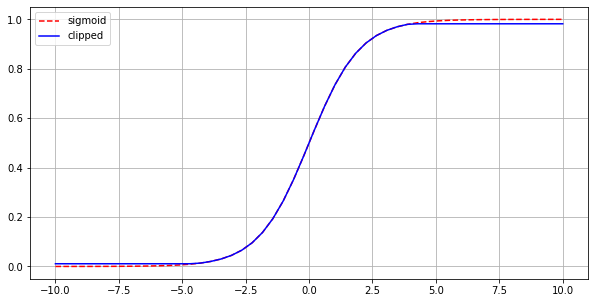

In [21]:
x = np.linspace(-10,10,50)

plt.figure(figsize=(10,5))
plt.plot(x, sigmoid(x), 'r', ls='--', label='sigmoid')

min_val = -4.5
max_val = 4
plt.plot(x, sigmoid(np.clip(x, min_val, max_val)), 'b', label='clipped')
plt.legend ()
plt.grid()

* $\text{The numpy clip function prevents the input from going outside a certain interval. }$


* $\text{This effectively avoids overflow in the exponential, but also causes a small approximation error.}$

* $\textbf{Another source of overflow: normalizing factor of a  distribution}$
<br>


$ \text{Many probability desity functions can be written as following:}$
<hr>
<br>
$$\boxed{\Large{
p(x) = \frac1Z \exp\Big(f(x)\Big)
}}$$
<br>

* $\text{Example of such pdfs: Gaussian, Multinomial, Dirichlet, Exponential, Poisson...}$

* $\text{Machine learning algorithms often use these distributions, because their parameters can be learned easily.}$ 

$\text{For example, the mean parameter of a Gaussian distribution can be estimated by computing the empirical mean of the data,}$ 


$\text{and the scale parameter can be learned by computing the empirical standard deviation.}$

* $\text{On the other hand, these probability functions have a risk of overflow due to the exponential function.}$

## $$\textbf{Unnormalized discrete density}$$
<hr>
<br> 

In [25]:
x = np.linspace(-2,6, 100).astype(np.float32)

f = lambda x: -(x - 2)**2/2
p = lambda x, Z = 1: np.exp(f(x))/Z

31.017876


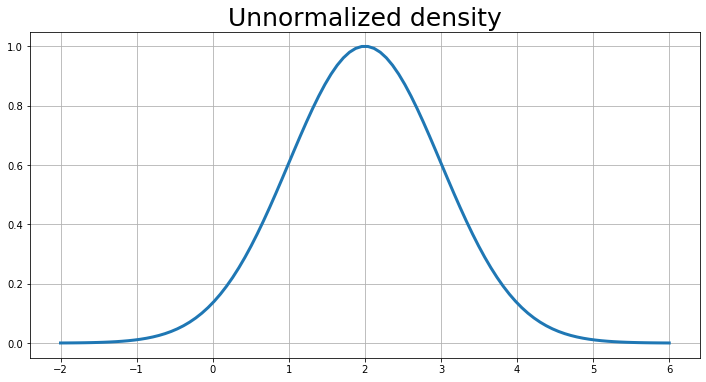

In [26]:
plt.figure(figsize=(12,6))
plt.title('Unnormalized density', fontsize=25)
plt.plot(x, p(x), linewidth=3)
plt.grid()
print(p(x).sum())

## $$\textbf{Normalized discrete density}$$
<hr>
<br> 


$$\sum_{x} p(x) = \frac{1}{Z}\sum_{x} \exp(f(x)) = 1\quad \Rightarrow\quad Z = \sum_{x} \exp(f(x))$$

1.0000001 <class 'numpy.float32'>
True


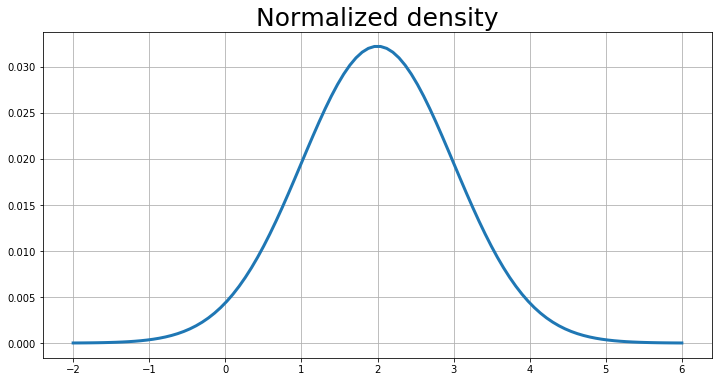

In [118]:
Z = p(x).sum()

plt.figure(figsize=(12,6))
plt.title('Normalized density', fontsize=25)
plt.plot(x, p(x, Z), linewidth=3)
plt.grid()

val = p(x,Z).sum()
print(val, type(val))
print(np.isclose(1., val, rtol=1e-6))

#np.testing.assert_allclose(1., val)

## $$\textbf{Log-density function}$$
<hr>
<br> 

* $\text{Numerically stable pdf computation}$
<br>
<br>

$${\Large{
\ln p(x) = -  \ln Z + f(x)
}}$$

## $$\textbf{Poisson probability mass function}$$
<hr>
<br> 

$$\Large{
p(k | \lambda) = {\frac{\lambda^k}{k !}} \exp(-\lambda), \quad k \geq 0
}$$

In [60]:
from scipy.special import factorial

def poisson_pmf(k, lambd):
    return lambd**k * np.exp(-lambd)/factorial(k) 

In [61]:
from scipy.stats import poisson

# Draw samples from Poisson distribution
lambd = 3

pos = poisson(lambd)
k =  np.sort(pos.rvs(500))

print(np.mean(k))
print(k[[20, 294, 335, -1]])

2.984
[0 3 4 9]


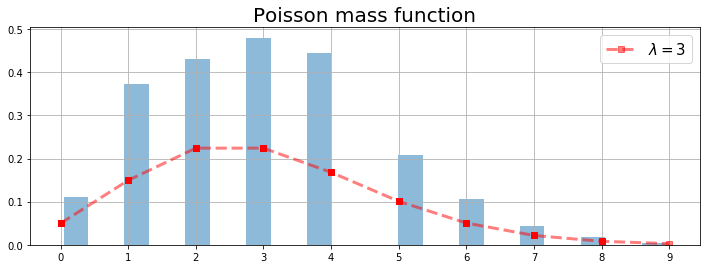

In [62]:
pmf = poisson_pmf(k, lambd)

plt.figure(figsize=(12,4))
plt.xticks(np.arange(10))
plt.title('Poisson mass function', fontsize=20)
plt.hist(k, bins=20, density=True, rwidth=0.8, alpha=0.5)
plt.plot(k,  pmf, 's--', linewidth=3, c='r', label='$\lambda=$'+f'{lambd}', alpha=0.5)
plt.legend(fontsize=15)
plt.grid()

## $$\textbf{Poisson log-probability mass function}$$
<hr>
<br> 


In [57]:
large_k = 100
poisson_pmf(large_k, lambd)

2.7494028058340025e-112

$$\Large{
\ln p(k |\lambda) = k \ln \lambda - \ln{k !}  -\lambda , \quad k \geq 0 }
$$

<hr>
$$\Large{
k ! = \Gamma(k + 1), \quad \Gamma(x) = \int_{0}^{\infty} t^{x - 1}\exp^{-t} dt 
}$$

In [58]:
from scipy.special import loggamma

def log_poisson_pmf(k, lambd):
    return k*np.log(lambd) - loggamma(k+1) - lambd 

In [63]:
log_pmf = log_poisson_pmf(k, lambd) 

np.allclose(pmf, np.exp(log_pmf))

True

## $$\textbf{Normalizing constant of a log-density function}$$
<hr>
<br> 

* $\text{Numerically stable pdf computation}$
<br>
<br>

$${\Large{
0 = \ln \sum_{x} p(x) = \ln\bigg[ \frac{1}Z \sum_{x} \exp {f(x)}\bigg] = -\ln Z + \ln\sum_{x} \exp(f(x))
}}$$



$$\Large{
\ln Z = \ln \underbrace{\sum_{x} \exp(f(x))}_{\text{sum of exp}}
}$$

## $$\textbf{Log-Sum-Exp trick}$$
<hr>
<br> 

* $\text{Given}\> x = \{x1, x2, \cdots, x_n\},\> \text{where}\> n \in \mathbb{N}$

$$ y = \ln \sum_{n=1}^N e^{x_n}\quad  \Rightarrow \quad e^y = \sum_{n=1}^N e^{x_n}$$

* $\text{Multiply both sides by}\> e^{-a} \neq 0 $
$$ e^{-a} e^y = e^{-a}\sum_{n=1}^N e^{x_n} \quad  \Rightarrow \quad e^{y-a} = \sum_{n=1}^N e^{x_n - a}$$

$$ {y-a} = \ln \sum_{n=1}^N e^{x_n - a} \quad  \Rightarrow \quad y = a + \ln \sum_{n=1}^N e^{x_n - a} $$

$$\boxed{y = \ln \sum_{n=1}^N e^{x_n} = a + \ln \sum_{n=1}^N e^{x_n - a},\quad a = \max(x_i),\quad i = \overline{1,\cdots,N}}$$

## $$\textbf{Linear Algebra}$$
<hr>
<br> 


#### $\textbf{Many machine learning techniques are based on linear algebra.}$ 

<br>

* $\text{Trace operator and matrix norms}$ 
<br>

* $\text{Solving a system of linear equations}$
<br>

* $\text{Singular value decomposiotion}$

### $$\textbf{Trace operator}$$
<hr>
<br> 

$$ tr(X) = \sum_{i=1}^N X_{ii}, \quad X \in \mathbb{R}^{(N,M)}$$
<hr>

* $\text{Usefull Properties}$:

$$ a = tr(a),\quad a \in \mathbb{R} $$

$$ tr(A) + tr(B) = tr( A + B)$$

$$ tr(ABC) = tr(CAB) = tr(BCA) $$

In [65]:
import numpy.random as rnd

X = rnd.normal(0, 1, size=(50,50))

assert np.diag(X).sum() == np.trace(X)

In [66]:
a = 10

A = rnd.normal(0,1,(10,20))
B = rnd.normal(0,1,(20,10))
C = rnd.normal(0,1,(10,10))

assert a == np.trace([[a]])

assert np.allclose(np.trace(A) + np.trace(B.T), np.trace(A + B.T)) 

assert np.allclose(np.trace(A @ B @ C),np.trace(C @ A @ B))
assert np.allclose(np.trace(C @ A @ B),np.trace(B @ C @ A))

## $$\textbf{Matrix norms}$$
<hr>
<br>  

* $\text{Frobenius norm with trace operator:}$

$$|| X ||_{Fro} = \sqrt{tr(XX^{\top})}$$

In [77]:
l2_norm = lambda X: np.trace(X @ X.T)**0.5

In [78]:
import numpy.linalg as la

X = rnd.normal(0,1, size=(10,20))

np.allclose(l2_norm(X), la.norm(X, ord='fro')) # ord = {'inf', 'nuc', p-norm }

True

## $$\textbf{Sum of row vectors with Trace}$$
<hr>

$$X \in \mathbb{R}^{(N,D)} $$

$$y = \sum_{n=1}^N x_{n} x_n^{\top} = {\sum_{n=1}^N tr(x_n^{\top}x_n)} = tr{(X^{\top} X)}$$

In [75]:
X = rnd.normal(0,1, size=(10,20))

y = np.sum([x @ x.T for x in X])

print(y, np.trace(X.T @ X))

np.allclose(y, np.trace(X.T @ X), atol=1e-17)

215.20588262346007 215.20588262346007


True

## $$\textbf{Solving a system of linear equations}$$
<hr>

Like
$$ 3x_0 + x1 = 9, \quad x_0 + 2x_1 = 8$$
or
$$ A X = B, \quad A = [[3,1],[1,2]] \quad B = [9,8]$$

In [80]:
A = [[3,1],[1,2]]
B = [9,8]

X = la.solve(A, B)

print(B, A @ X)

assert np.allclose(A @ X, B)

[9, 8] [9. 8.]


## $$\textbf{Linear regression}$$
<hr>

* $\text{The model assumes that the data is generated as following:}$

$$
y_n = \beta_1 x_n + \beta_2 + \epsilon_n, \quad n = \overline{1..N},\quad \epsilon_n \sim \mathcal{N}(0,\sigma^2)
$$

$\text{or}$

$$
y = \beta_1\hat{X} + \beta_2\mathbb{1}_{N} + \mathcal{E}, \quad \text{where}  \quad y, \hat{X} , \mathcal{E} \in \mathbb{R}^{(N,1)} 
$$

## $$\textbf{Linear regeression matrix form}$$
<hr>

$$
y = [ \beta_1, \beta_2 ] \times [ \hat{X} , \mathbb{1}_{N}]^{\top} + \mathcal{E}
$$
<hr>
$$
y = \beta \times {X}^{\top} + \mathcal{E}, \quad \text{where} \quad \beta = [\beta_1,\beta_2] \in \mathbb{R}^{(2)}, \quad \text{and} \quad X = [ \hat{X} , \mathbb{1}_{N}] \in \mathbb{R}^{(N,2)}
$$
<br>

$\textbf{**Task**}\> \text{Find the best linear fit of a labeled dataset.}$

## $$\textbf{Toy data generation}$$
<hr>


(250, 2)
(250,)


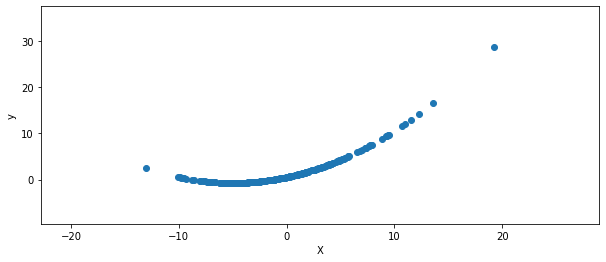

In [82]:
# Create a dataset
rnd.seed(42)

N = 250 # number of data points

X = np.random.normal(0, 5, size = (N, 1))

X_ones = np.ones_like(X)

X = np.c_[(X, X_ones)] # column-wise concatenation

print(X.shape)

# Create targets (outputs) and make them depend on X in some way
y = 0.5 * X[:, 0] + 0.05 * X[:, 0] ** 2 + 0.5
print(y.shape)

plt.figure(figsize = (10,4))
plt.scatter(X[:, 0], y)
plt.xlabel('X')
plt.ylabel('y')
plt.margins(0.3)

* $\textbf{Add some random noise}\> \mathcal{E}_n \sim \mathcal{N}(0, \sigma^2)$

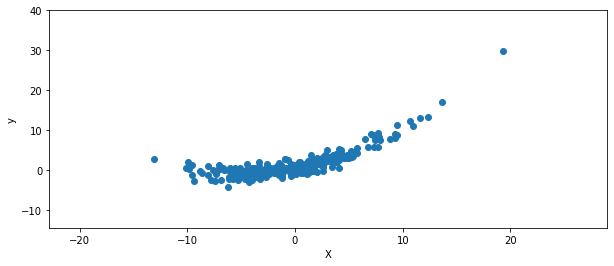

In [84]:
sigma2 = 1

Eps = np.random.normal(0, sigma2, (N)) # random noise

y += Eps # add noise to the targets

plt.figure(figsize = (10,4))
plt.scatter(X[:, 0], y)
plt.xlabel('X')
plt.ylabel('y')
plt.margins(0.3)

* $\text{Split dataset randomly into *train* and *test* datasets}$

In [86]:
# Use a function from sklearn package

from sklearn.model_selection import train_test_split

split_ratio = 0.8

X_tr, X_te, y_tr, y_te = train_test_split(X, y, 
                                          test_size=1-split_ratio, 
                                          random_state=42)

## $$\textbf{Linear regeression analytic solution}$$
<hr>

* $\text{The solution of the linear regression model is given by:}$
<hr>

$${\boxed{\beta = (X_\text{tr}^\top X_\text{tr})^{-1} X_\text{tr}^\top y_\text{tr}}}$$

* $\text{And the prediction for new "test" points by:}$
<hr>

$${\hat y_\text{te} = X_\text{te} \beta}$$

In [87]:
beta = la.inv(X_tr.T @ X_tr) @ X_tr.T @ y_tr

y_te_predict = X_te @ beta

beta

array([0.58857575, 1.72534516])

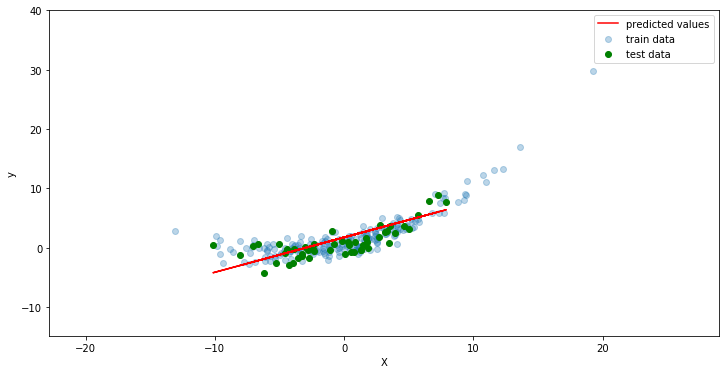

In [89]:
# Plot the data and the prediction
plt.figure(figsize = (12,6))
plt.scatter(X_tr[:, 0], y_tr, alpha=.3, label='train data')
plt.scatter(X_te[:, 0], y_te, color='g', label='test data')
plt.xlabel('X')
plt.ylabel('y')

plt.plot(X_te[:, 0],y_te_predict, '-', color='r', label='predicted values')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.margins(0.3)

* $\textbf{Compute the *root mean square error* (RMSE) for the predicted outputs:}$
<hr>

$$\text{RMSE} = \sqrt{\frac{1}{N}\sum_{n=1}^N(\hat{y}_{\text{te}_n} - y_{\text{te}_n} )^2}$$
<br>

In [90]:
rmse = np.square(y_te_predict - y_te).mean()**0.5

f"RMSE: {rmse:0.2f} where y_tr std: {np.std(y_tr):0.3f}"

'RMSE: 1.86 where y_tr std: 3.707'

## $$\textbf{Principal component analysis (PCA)}$$
<hr>



$\text{PCA is a technique widely used for applications such as}$

 * $\text{dimensionality reduction}$
 * $\text{lossy data compression}$
 * $\text{feature extraction}$
 * $\text{data visualization}$

$\text{There are two commonly used definitions of PCA:}$

 * $\text{Orthogonal projection onto lower dimensional linear space
    such that the variance of projected data is maximized.}$
    
 * $\text{Linear projection that minimizes the average projection}$
    $\text{cost, defined as the mean squared distance between the
    data and their projections.}$

## $$\textbf{Singular value decomposition (SVD)}$$
<hr>


$\text{The Singular-Value Decomposition, or SVD for short,}$

$\text{is a matrix decomposition method for reducing a matrix to its constituent parts}$

$\text{in order to make e.g. certain subsequent matrix calculations like matrix inversion simpler.}$

<br><br>

<center>
    <img src="./images/SVD.png" width='400'/>

## $$\textbf{Create a random dataset with correlated feature dependency}$$
<hr>

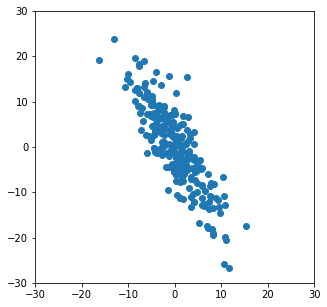

In [91]:
rnd.seed(42)
N = 250
M = np.random.normal(0, 5, (N, 2))

# create some correlation between dimensions
M[:, 1] -= 1.5 * M[:, 0]

# Plot the centered dataset
plt.figure(figsize=(5, 5))
plt.scatter(*M.T)

_=plt.axis([-30, 30, -30, 30])

## $$\textbf{Find the principal components via SVD}$$
<hr>


In [101]:
# PCA only applies to centered data, so we center the data
M -= M.mean(axis=0)

U, Sigma, V = la.svd(M , full_matrices = False)

print("U shape: ", U.shape)
print("Sigma shape:", Sigma.shape)
print("V shape:", V.shape)

X = U @ np.diag(Sigma) @ V.T # SVD reconstruction

assert np.allclose(np.sum(M - X) , 0)

U shape:  (250, 2)
Sigma shape: (2,)
V shape: (2, 2)


## $$\textbf{Project any point to the axis representing highest data variance}$$
<hr>


In [103]:
HAT1 = np.outer(V[0], V[0]) # 1st component
HAT2 = np.outer(V[1], V[1]) # 2d component

Mtest = rnd.uniform(-20, 20, (500, 2)) # random test data to project

# Project some test data onto the fisrt principal compenent
MtestPCA1 = Mtest @ HAT1

# Project some test data onto the second principal compenent
MtestPCA2 = Mtest @ HAT2

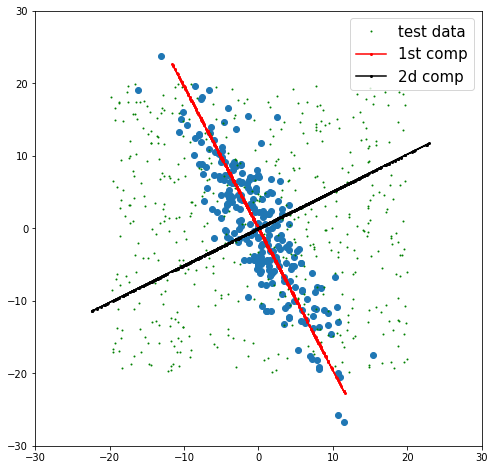

In [104]:
# Plot the original data and the projected test data
plt.figure(figsize=(8, 8))

plt.scatter(*M.T)  # equivalent to M.T[0], M.T[1]

plt.plot(*Mtest.T, 'o', color='g', ms=1, label='test data')
plt.plot(*MtestPCA1.T, 'o-', color='r', ms=2, label='1st comp')
plt.plot(*MtestPCA2.T, 'o-', color='k', ms=2, label='2d comp')
plt.legend(fontsize=15)
_= plt.axis([-30, 30, -30, 30])

## $$\textbf{Sklearn PCA}$$
<hr>

In [105]:
from sklearn.decomposition import PCA

In [106]:
pca = PCA(n_components=2)

pca.fit(M) # N, 100
print(Mtest.shape)

M_pr = pca.transform(Mtest)
M_pr.shape

(500, 2)


(500, 1)

## $$\textbf{Thank you for your attention}$$